# Text Sentiment Classification

Classification of the sentiment in [IMDB movie reviews](https://ai.stanford.edu/~amaas/data/sentiment/) with a Neural Network (built with Keras and a custom wrapper).

<a id='index'></a>
## Index

- [Data preprocessing](#preprocessing)
- [Neural Network with Keras](#classifier)
    - [Feature extraction](#feature_extraction)
    - [Cross-validation](#cross_validation)

<a id='preprocessing'></a>
## Data preprocessing

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

from preprocessing import preprocess
from validation import report_results
from validation import plot_confusion_matrix
from custom_keras_wrapper import KerasClassifier

Using TensorFlow backend.


In [4]:
IMDB_MOVIE_REVIEWS_ROOT = 'aclImdb'

train_data, test_data = preprocess(IMDB_MOVIE_REVIEWS_ROOT)

print("Number of training examples: %d" % len(train_data))
print("Number of test examples: %d\n" % len(test_data))

print(train_data.head(5))

Number of training examples: 25000
Number of test examples: 25000

                                              review  sentiment
0  I liked this movie very much because it is a t...          1
1  Joan Fontaine stars as the villain in this Vic...          1
2  We watched this on "The Wonderful World of Dis...          1
3  I claim no matter how hard I seek I'll never f...          1
4  There I was sitting alone in my flat on a Satu...          1


<a id='classifier'></a>
## Neural Network with Keras

The following classifier is based on a Neural Network built with a custom wrapper for [Keras](https://keras.io/) deep learning library. The custom wrapper (made by me) has the basic sklearn signatures such as *fit*, *predict*, and *score* which allow for an easy interaction with the rest of sklearn tools, e.g. [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) etc.

<a id='feature_extraction'></a>
### Feature extraction

[back to index](#index)

In [5]:
vectorizer, one_hot_enc = TfidfVectorizer(max_features=1000), OneHotEncoder()

X_train = vectorizer.fit_transform(train_data['review']).toarray()
y_train = np.reshape(train_data['sentiment'].values, (len(train_data), 1))
y_train = one_hot_enc.fit_transform(y_train).toarray()  

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_test = vectorizer.transform(test_data['review']).toarray()
y_test = np.reshape(test_data['sentiment'].values, (len(test_data), 1))
y_test = one_hot_enc.transform(y_test).toarray()  

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (25000, 1000)
y_train shape:  (25000, 2)
X_test shape:  (25000, 1000)
y_test shape:  (25000, 2)


In [6]:
'''
# The default achitecture/structure of the Neural Network is defined in the custom_keras_wrapper.py as default
# Custom achitectures/structures can be pass via structure parameter in the KerasClassifier constructor

DEFAULT = [
    (
        Dense, {
            'units' : 512, 
            'activation' : 'relu'
        }
    ), 
    (Dropout, {'rate' : 0.5}), 
    (Dense, {'activation' : 'softmax'})
]
'''

classifier = KerasClassifier(
    batch_size=1000,
    epochs=100,
    optimizer='rmsprop'
)

<a id='cross_validation'></a>
### Cross-validation

[back to index](#index)

In [7]:
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)

print("\n")
report_results(cv_scores)

5000/5000 [==============================] - 0s 33us/step


Cross-Validation (CV) results:

Min test score: 76.94% 				<- worst case
Max test score: 87.80% 				<- best case
Mean test score: 82.64% +- 7.73% (95% conf.) 	<- expected performance

95/100 times the test score will be in range 74.92-90.37%


25000/25000 [==============================] - 1s 26us/step


Test score: 85.50%


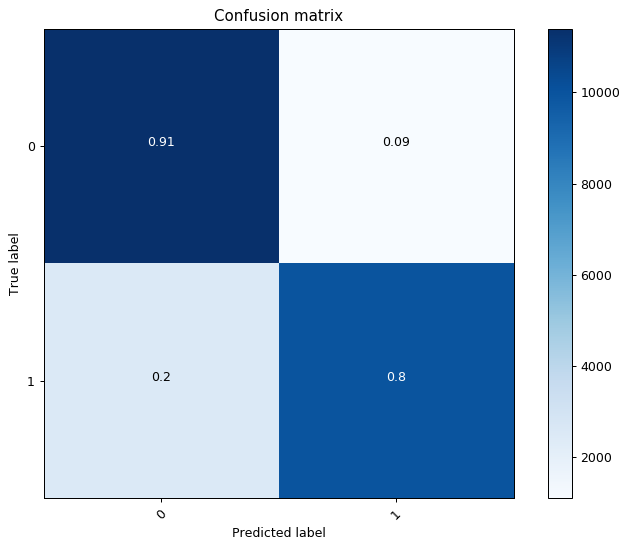

In [8]:
classifier.fit(X_train, y_train)

print("\n\nTest score: %.2f%%" % (100 * classifier.score(X_test, y_test)))

y_test_pred = classifier.predict(X_test)
y_test_pred = [np.argmax(predictions) for predictions in y_test_pred]

plot_confusion_matrix([np.argmax(_) for _ in y_test], y_test_pred)